In [1]:
import pathlib
import numpy as np
from fytok.Tokamak import Tokamak
from spdm.view import View as sp_view

input_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

2023-11-14 15:31:36,063 [   fytok]     INFO: 
#######################################################################################################################
    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = develop  (spdm=develop extension=0.2.2.dev11+g706f667, imas_version=v3_38_1_dirty)

 Run by salmon at 2023-11-14T15:31:36.063321.
 Job ID: fytok_salmon_surface_5030

#######################################################################################################################



In [2]:
tokamak = Tokamak(
    f"file+iterprofiles://{next(input_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(input_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    time=2.30,
    core_transport={"model": [{"code": {"name": "dummy"}}]},
    core_sources={
        "source": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fusion_reaction"}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 0.995, 128),
                "bvp_rms_mask": [0.96],
                "hyper_diff": 0.0001,
                "max_nodes": 250,
                "equations": {
                    "ion/D/density_thermal": {
                        "profile": 1.5e19,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [2.0e19]},
                        ],
                    },
                    "ion/T/density_thermal": {
                        "profile": 1.5e19,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [2.0e19]},
                        ],
                    },
                    "ion/D/temperature": {
                        "profile": 1000,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [1000]},
                        ],
                    },
                    "ion/T/temperature": {
                        "profile": 1000,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [1000]},
                        ],
                    },
                    "electrons/temperature": {
                        "profile": 1000,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [1000]},
                        ],
                    },
                },
            },
        }
    },
)

2023-11-14 15:31:36,364 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_iterprofiles
2023-11-14 15:31:36,420 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_geqdsk
2023-11-14 15:31:36,437 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.transport_solver_numerics.fy_trans
2023-11-14 15:31:36,763 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.equilibrium.fy_eq
2023-11-14 15:31:36,766 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.core_transport.model.dummy
2023-11-14 15:31:36,770 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_exp

In [3]:
tokamak.refresh()
# boundary_condition={
    #     "ion/D/density_thermal": [[0.0], [2.0e19]],
    #     "ion/T/density_thermal": [[0.0], [2.0e19]],
    #     "ion/D/temperature": [[0.0], [1000]],
    #     "ion/T/temperature": [[0.0], [1000]],
    #     "electrons/temperature": [[0.0], [1000]],
    # },   

2023-11-14 15:31:36,802 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.mesh.mesh_rectangular
2023-11-14 15:31:37,883 [   fytok]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/transport_solver_numerics/fy_trans.py:234:_update_coefficient: dummy
2023-11-14 15:31:37,940 [   fytok]     INFO: Solve transport equations [5] : ion/D/density_thermal,ion/T/density_thermal,ion/D/temperature,ion/T/temperature,electrons/temperature
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          5.48e-01       3.83e-01          128            28       
       2          2.51e-02       1.03e-10          156            31       
       3          6.99e-03       5.40e-12          187             9       
       4          3.73e-03       5.68e-14          196             1       
       5          9.93e-04       2.84e-14          197             0       
Solved in 5 iterations, number of

2023-11-14 15:31:41,422 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.view.view_matplotlib


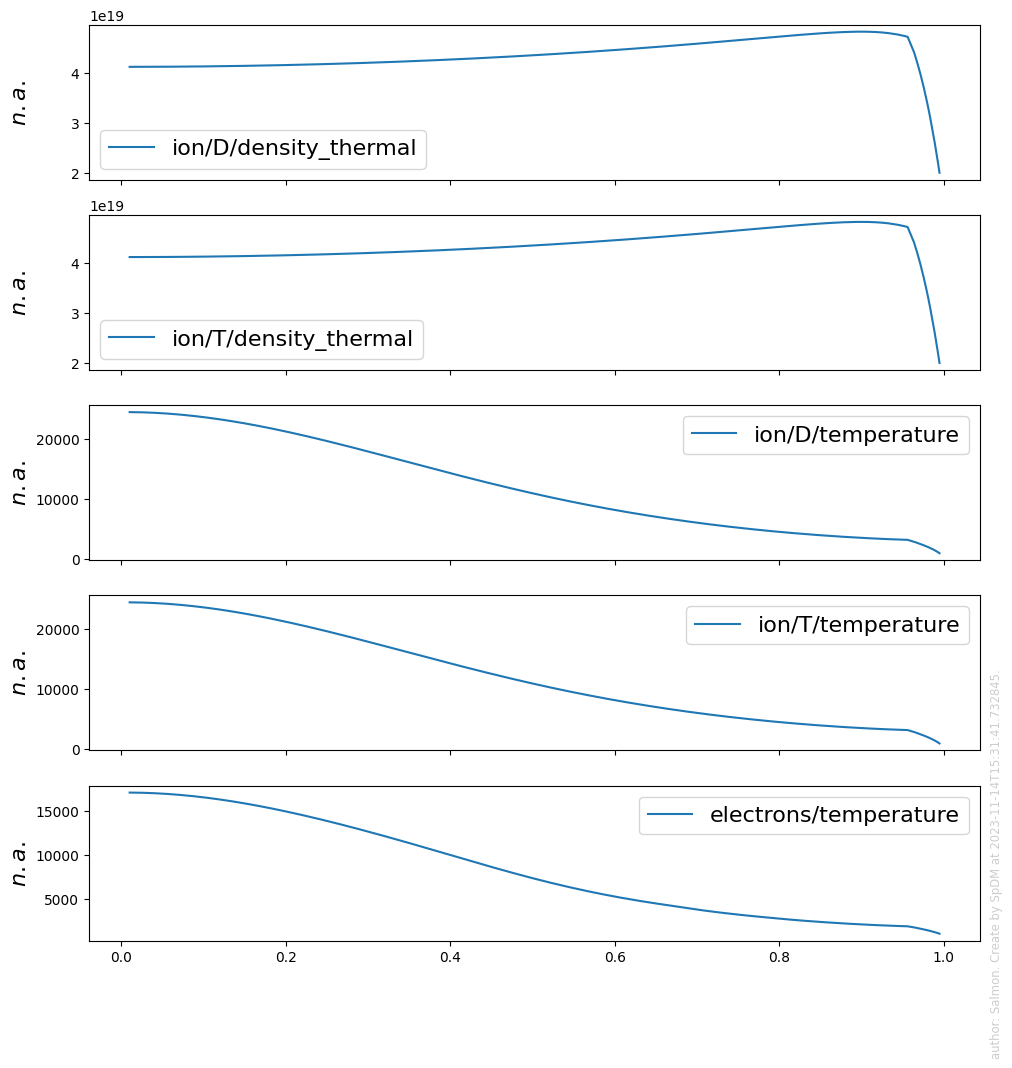

In [4]:
solver_1d = tokamak.transport_solver.time_slice.current.solver_1d
fig = sp_view.plot(
    sum(
        [
            [
                (equ.primary_quantity.profile, equ.primary_quantity.identifier),
                # (equ.primary_quantity.flux, f"{equ.primary_quantity.identifier}_flux"),
                # (equ.primary_quantity.d_dr,f"d({equ.primary_quantity.identifier})/dr"),
                # (equ.primary_quantity.dflux_dr, f"d({equ.primary_quantity.identifier}_flux)/dr"),
            ]
            for equ in solver_1d.equation
        ],
        [],
    ),
    x_axis=solver_1d.grid.rho_tor_norm,
)

In [5]:
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d

2023-11-14 15:31:42,648 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:327:plot: Plot [index=0] failed! y_label= "None"  [Function.compile() incorrect value shape (153,)!=(197,)! func=None ] 
2023-11-14 15:31:42,657 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:327:plot: Plot [index=2] failed! y_label= "None"  [Function.compile() incorrect value shape (153,)!=(197,)! func=None ] 


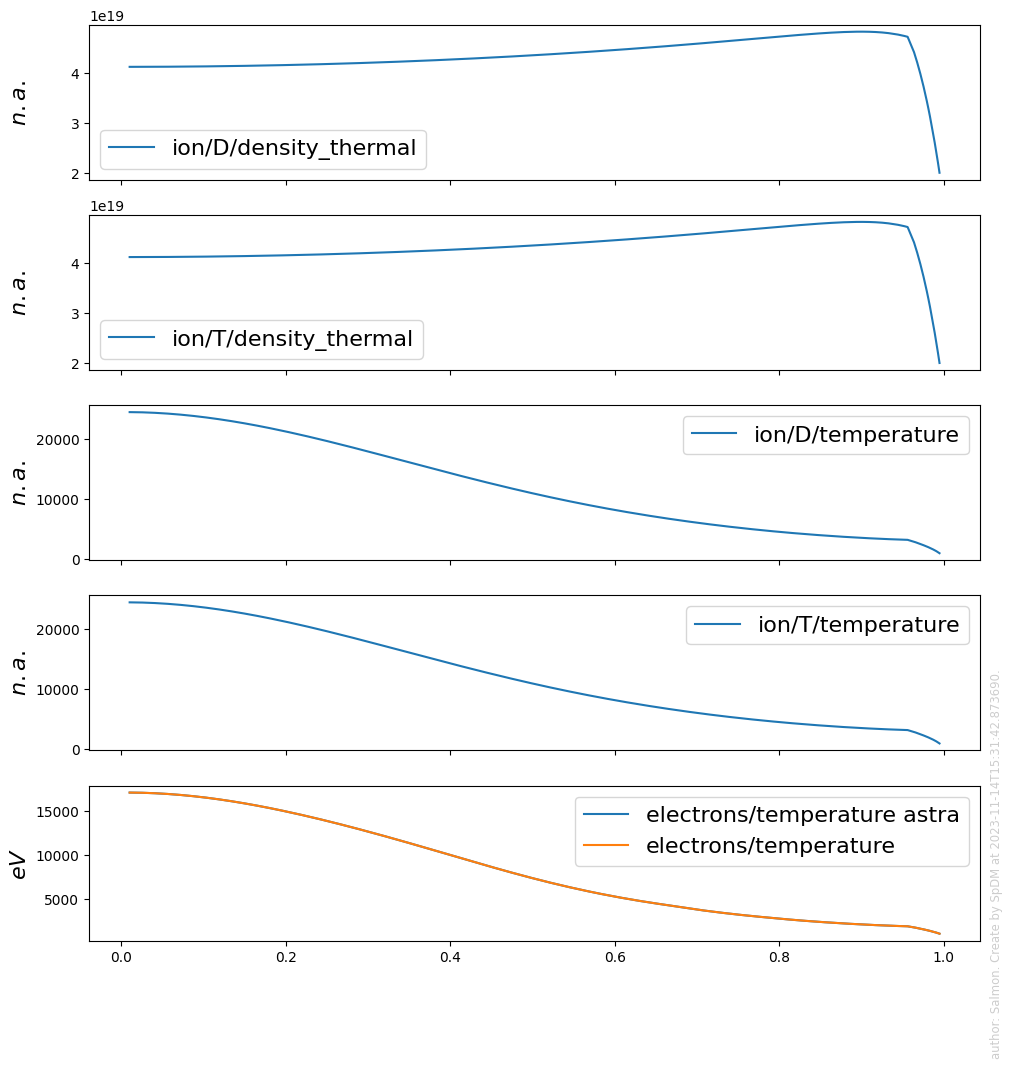

In [6]:
fig = sp_view.plot([
    [
        (core_profiles_1d.get(equ.primary_quantity.identifier), rf"{equ.primary_quantity.identifier} astra"),
        (equ.primary_quantity.profile, rf"{equ.primary_quantity.identifier}")
    ] for equ in solver_1d.equation
],
    x_axis=solver_1d.grid.rho_tor_norm
)

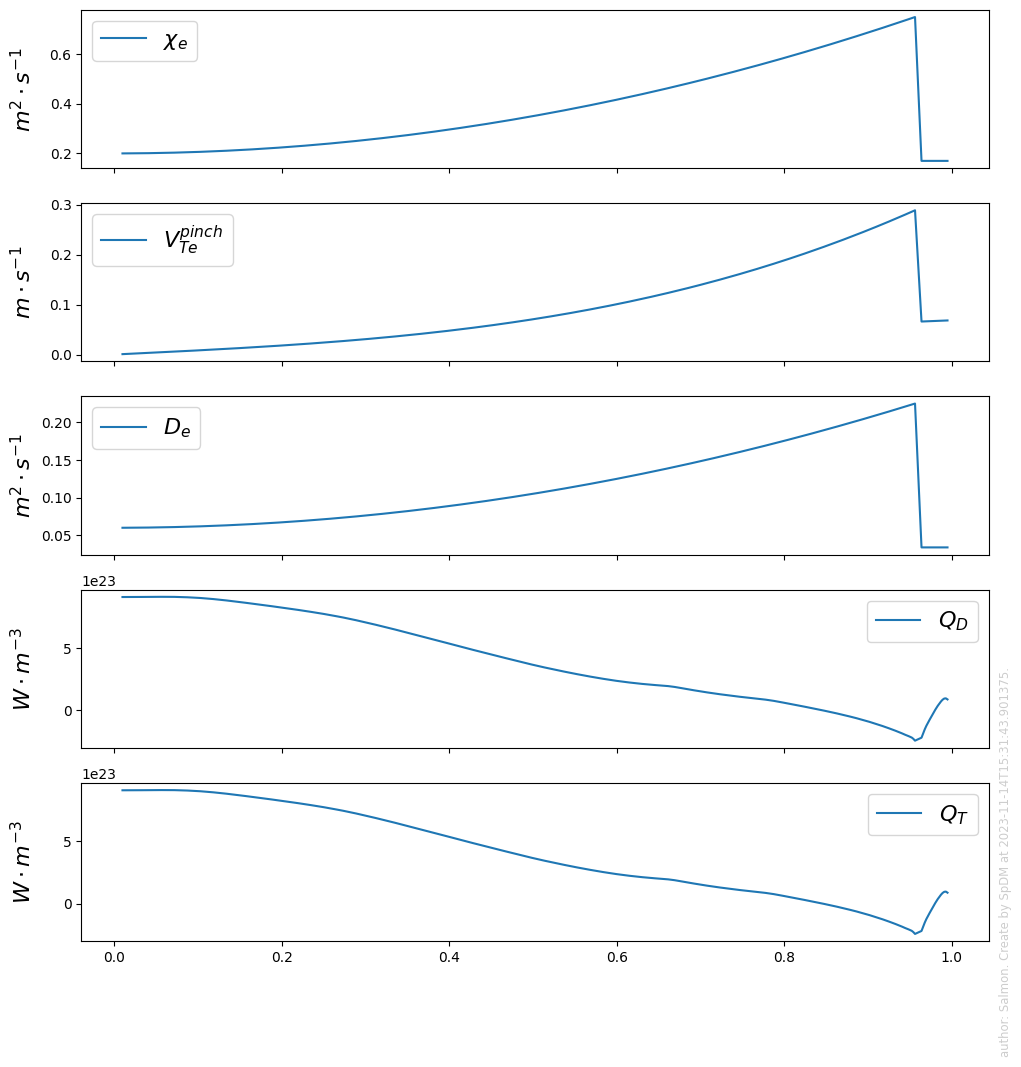

In [7]:
core_sources_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
core_transport_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d

fig = sp_view.plot(
    [
        # (core_sources_1d.electrons.energy, r"$Q_e$"),
        (core_transport_1d.electrons.energy.d, r"$\chi_e$"),
        (core_transport_1d.electrons.energy.v, r"$V^{pinch}_{Te}$"),
        # (core_sources_1d.electrons.energy_decomposed.explicit_part, r"$Q_{e}$ explicit"),
        # (core_sources_1d.electrons.energy_decomposed.implicit_part, r"$Q_{e}$ implicit"),
        (core_transport_1d.electrons.particles.d, r"$D_e$"),
        (core_sources_1d.ion[0].energy, r"$Q_D$"),
        (core_sources_1d.ion[1].energy, r"$Q_T$"),
    ],
    x_axis=solver_1d.grid.rho_tor_norm,
)

2023-11-14 15:31:44,817 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:327:plot: Plot [index=5] failed! y_label= "None"  [Variable n_{T} require 4 args, but only 1 provided!] 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


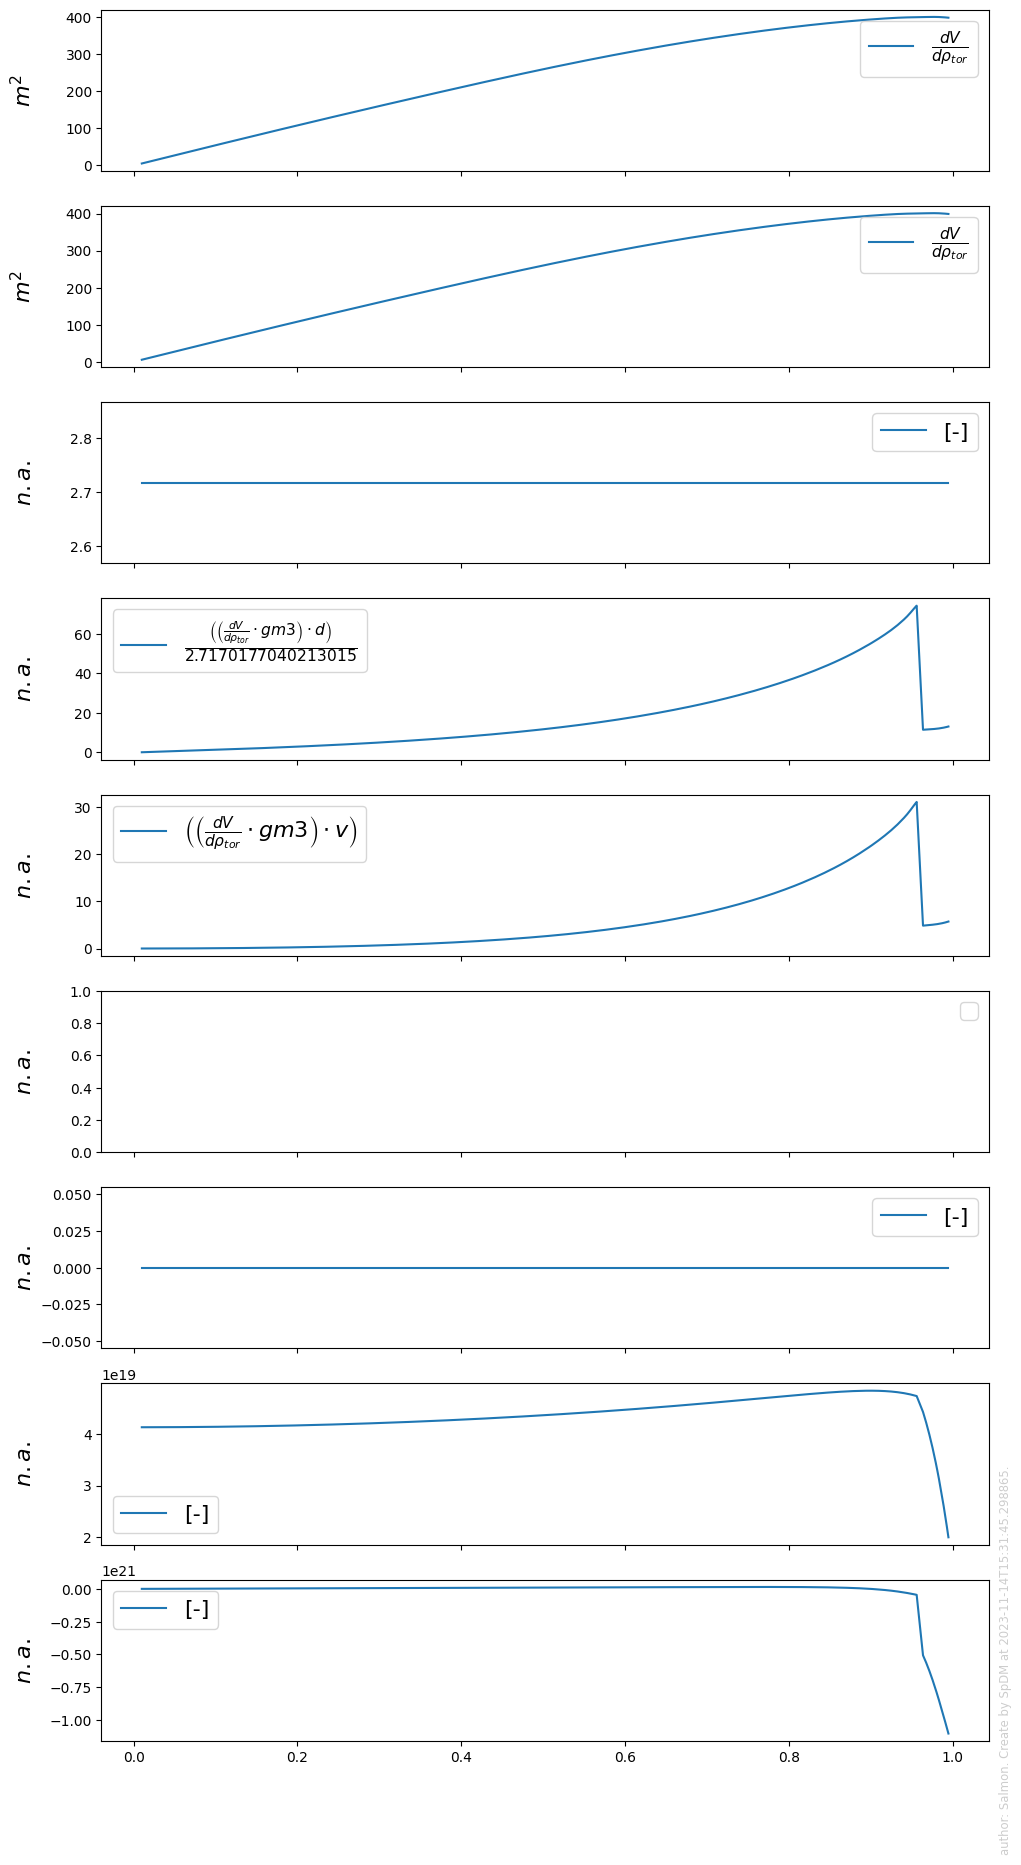

In [8]:
equ = solver_1d.equation[1]
a, b, c, d, e, f, g,*_ = equ.coefficient
x = solver_1d.grid.rho_tor_norm
y       = equ.primary_quantity.profile
yp      = equ.primary_quantity.d_dr
flux    = equ.primary_quantity.flux
dflux   = equ.primary_quantity.dflux_dr
fig = sp_view.plot([
    a, b, c, d, e, f, g,
    # [
    #     (d*yp, "$D$"),
    #     (e*y,   "$v$"),
    #     # (flux,   f"$\Gamma$"),
    #     ((c*(f - g * y)).I, r"$S$"),  # $\int c*(f - g \cdot y)$
    #     # ((-d*yp+e*y).I, r"$\Gamma$"),
    #     (-d*yp+e*y-(c*(f - g * y)).I, "residual"),

    # ],
    y, yp

    # [

    #     (dflux, {"label": r"$d\Gamma$"}),
    #     # (Function(flux, x).d(), r"$d\Gamma$"),
    #     ((c*(f - g * y)), r"$c*(f - g \cdot y)$"),
    # ],
],
    x_axis=x)